# Lab 12 - Spectral Clustering

In this lab, you will learn how to use spectral methods on graph clustering.

After filling this notebook and running all the cells, rename the file **lab12.ipynb** to **netid_lab12.ipynb**, include your **well commented** code, and submit it by email. Avoid unneeded steps/computations and make sure your code runs before submitting it. Grading is based on your submission which is due at **9 p.m. Dec 5, 2017**. There is no late policy. No late submissions will be accepted.

You will need to install [numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/install.html) and [sklearn](http://scikit-learn.org/stable/) for this lab. Use this command `pip install --user numpy` and `pip install --user sklearn` to install numpy on your machine. 

You will need the following helper function.

In [46]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
import numpy as np
from __future__ import division

rnd.seed(2333)

def draw_graph(graph, labels=None, graph_layout='spring',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    rcParams['figure.figsize'] = 12, 12  # that's default image size for this interactive session
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()

## Problem 1: Representing Graphs as Adjacency Matrix (10 pts)

In previous labs, we use an adjacency list to represent a graph $G=(V,E)$. Starting from now, we will represent a graph using an adjacency matrix `A`, where `A[i,j] = 1` indicates there is an edge between node `i` and node `j` and `A[i,j] = 0` indicates there is no edge in between. For simplicity, we will represent `A` using a numpy array.

For visualization, write a function that convert the randomly generated graphs (as an adjacency matrix) into its a list of edge tuples.

In [47]:
def adjacency_to_graph(adjacency):
    assert all(adjacency == adjacency.T)
    graph = []
    # your code goes here
    # populates the graph list with a tuple of vertices that represents the edge as well
    for i in range(adjacency.shape[0]):
        for j in range(adjacency.shape[1]):
            if adjacency[i, j] == 1:
                graph.append((i,j))
    return graph

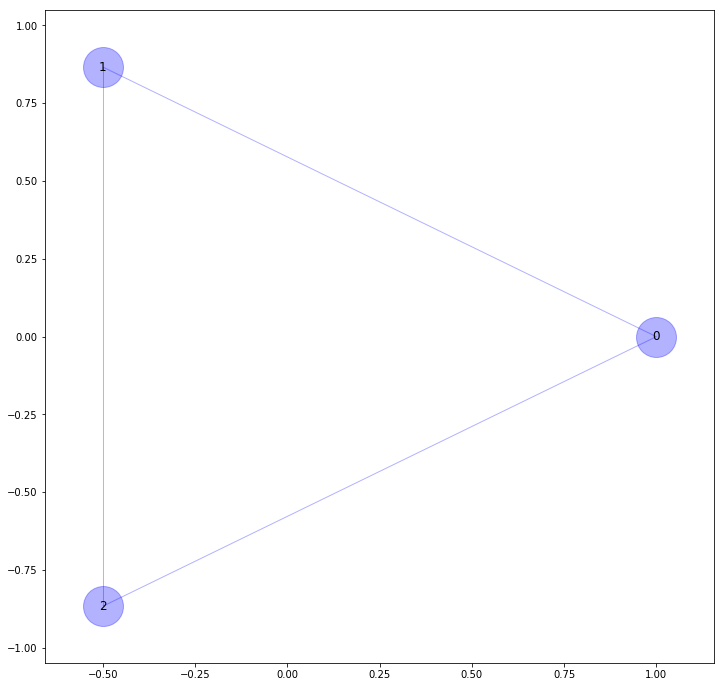

In [48]:
# sanity check
adjacency = np.array([[0, 1, 1], 
                      [1, 0, 1], 
                      [1, 1, 0]])
graph = adjacency_to_graph(adjacency)
draw_graph(graph, graph_layout='shell')

## Problem 2: Erdős-Rényi Graphs (10 pts)
In this problem, we explore a class of random graphs introduced by [Erdős and Rényi](http://www.renyi.hu/~p_erdos/1959-11.pdf). 
The Erdős-Rényi model states that given $n$ nodes, any pair of nodes $(i,j)$ are connected with probability $p$.


Fill out the following function to create an Erdős–Rényi random graph ${G}(n,p)$. For each pair of nodes, randomly create an edge between them with probability $p$. Return the resulting graph as its adjacency matrix. 

In [49]:
def G(n, p):
    '''
    output a graph by its adjacency matrix
    '''
    graph = np.zeros((n, n))
    # your code goes here
    # I set a "probability level" out of 100. Then for every pair of nodes, I generate a random int between 0-100 and see
    # if it falls under my probablity level. Then I update the edge and back edge between both nodes
    
    prob = p*100
    for i in range(n):
        for j in range(n):
            p_level = rnd.randint(0, 100)
            if p_level <= prob:
                graph[i, j] = 1
                graph[j, i] = 1
    return graph

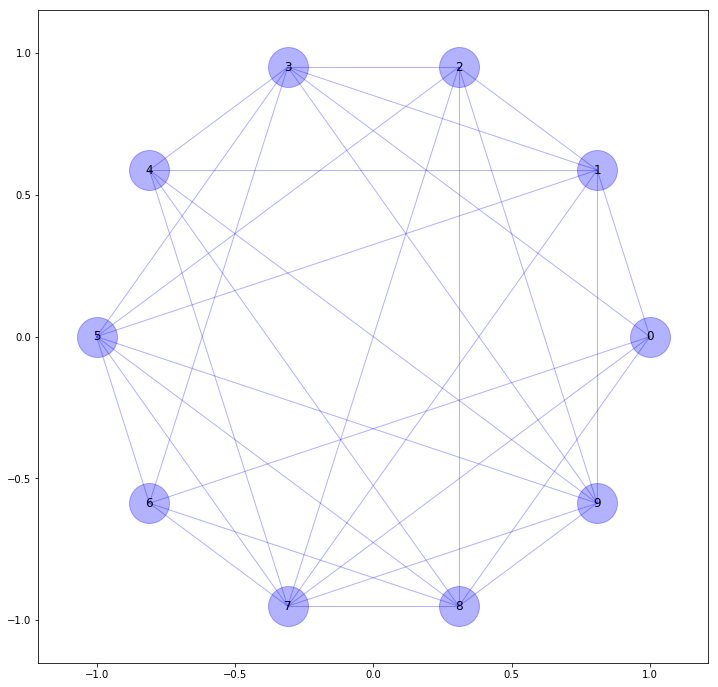

In [50]:
# visualize this randomly generated graph
graph = adjacency_to_graph(G(10, 0.5))
draw_graph(graph, graph_layout='shell')

## Problem 3: Stochastic Block Model (10 pts)

The [stochastic block model](https://en.wikipedia.org/wiki/Stochastic_block_model) (SBM) is a generative model for random graphs. This model tends to produce graphs containing communities. SBM is parameterized by $n$, $k$, $p$ and $q$: $n$ is the number of vertices, $k$ is the number of communities, $p$ is the probability of an edge existing between any two nodes within a community and $q$ is the probabiloty of an edge between two communities. We are interested in recovering the communities from a realization of the random graph.

For simplicity, we assume $n$ is a multiple of $k$, and node $i$ belongs to community $l$ iff $l\frac{n}{k} \le i < (l+1)\frac{n}{k}$, for all $i=0,1,...,n-1$ and $l=0,1,...,k-1$. 

Use the function you wrote in Problem 2 to implement the stochastic model.

In [51]:
def SBM(n, k, p, q):
    '''
    output a graph by a list of edge tuples
    '''
    assert (n % k == 0)
    graph = np.zeros((n, n))
    com_split = int(n/k)            # This will be the number of nodes per community  
    q_prob = q*100                  # Similar probability concept as the previous question
    com_assignments = []            # A list to hold the cluster assignments for every node
    
    count = 0
    community = 0
    for i in range(k):
        sub_graph = G(com_split, p)         # Creating a sub-adjacency matrix for each community
        for j in range(com_split):
            com_assignments.append(community)            # Assign each node in this group to the correct community
            for l in range(com_split):
                graph[j + count, l + count] = sub_graph[j, l]
        count += com_split
        community += 1
     
    # This code block updates inter community edges
    for i in range(n):
        for j in range(n):
            if com_assignments[i] != com_assignments[j]:
                if rnd.randint(0, 100) < q_prob:
                    graph[i, j] = 1
                    graph[j, i] = 1
    # your code goes here
    return graph

Try it out.

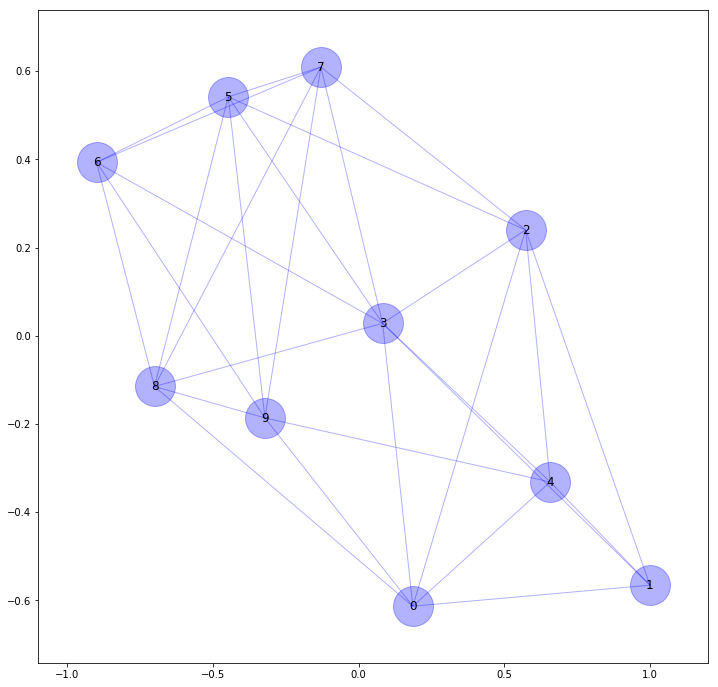

In [52]:
graph = adjacency_to_graph(SBM(10, 2, 1, 0.1))
draw_graph(graph)

## Problem 4: Laplacian of the Graph (10pts)

Once we have the adjacency matrix $A$ of the given graph, it's easy to calculate its [Laplacians](https://en.wikipedia.org/wiki/Laplacian_matrix) for spectral clustering. 

The Laplacian of a graph is defined as $L = D-A$, where $A$ is its adjacency matrix and $D$ is the degree matrix. Specifically, $D(i, i) = {\rm degree}(i)$ and $D(i,j) = 0$ for any $i\neq j$.

Fill in the following function to compute the Laplacian of the graph.

In [53]:
def get_laplacian(adjacency):
    '''
    return the Laplacian.
    '''
    laplacian = np.zeros(adjacency.shape)
    deg_matrix = np.zeros((adjacency.shape[0], adjacency.shape[1]))
    # your code goes here
    deg_count = 0
    # create a deg_matrix to hold the degree of each node
    for i in range(adjacency.shape[0]):
        for j in range(adjacency.shape[1]):
            if adjacency[i, j] == 1:
                deg_count += 1         
        deg_matrix[i, i] = deg_count
        deg_count = 0
    
    # Create the laplacian by subtracting the adjacency val from the deg_matrix for every node pair i,j
    for i in range(adjacency.shape[0]):
        for j in range(adjacency.shape[1]):
            laplacian[i, j] = deg_matrix[i, j] - adjacency[i, j]
            
    return laplacian

adjacency = np.array([[0, 1, 0, 0, 1, 0],
                      [1, 0, 1, 0, 1, 0],
                      [0, 1, 0, 1, 0, 0],
                      [0, 0, 1, 0, 1, 1],
                      [1, 1, 0, 1, 0, 0],
                      [0, 0, 0, 1, 0, 0]])
get_laplacian(adjacency)

array([[ 2., -1.,  0.,  0., -1.,  0.],
       [-1.,  3., -1.,  0., -1.,  0.],
       [ 0., -1.,  2., -1.,  0.,  0.],
       [ 0.,  0., -1.,  3., -1., -1.],
       [-1., -1.,  0., -1.,  3.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  1.]])

## Problem 5: Spectral Clustering (50pts)

The smallest eigenvalue of $L$ is equal to zero because $L$ times the all 1s vector is equal to zero. The next $k-1$ smallest eigenvalues usually determine the number of clusters. In other words, if you can find $k-1$ eigenvalues that are very close to zero, then the graph has $k$ commnunities. 

Spectral clustering uses the Laplacian $L$ with priori information on $k$. The inputs are the adjacency matrix $A$ and the number of clusters to be recovered. The first step consists in computing the eigenvectors corresponding to the lowest $k$ eigenvalues of $L$. 

Filling the function to get the eigenvectors of the Laplacian.

In [68]:
def get_vectors(laplacian, k):
    v = np.zeros((len(laplacian), k))
    # your code goes here
    w, eig_v = np.linalg.eig(laplacian)     # get eigenvalues and eigenvectors of the laplacian
    indices = np.argsort(w)
    for i in range(k):
        v[:, i] = eig_v[:, indices[i]]      # Only take the eigenvectors that correspond to the k smallest eigenvalues
    return v

Then one builds the $n\times k$ matrix $V$, whose colums are the $k$ eigenvectors. The $n$ rows of $V$ are used to represent the graph vertices in a $k$-dimensional Euclidean space. The points are then grouped in $k$ clusters by using $k$-means clustering. 

Fill in the code to perform $k$-means clustering on the $n\times k$ eigenvector $V$. The output is a $n$-dimensional vector where the $i$-th entry represents which cluster node $i$ belongs to. You may find [this page](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) useful. 

In [69]:
import sklearn
from sklearn.cluster import KMeans
def kmeans(v, k):
    labels = np.zeros(len(v))
    # your code goes here
    kmeans = KMeans(n_clusters = k).fit(v)     # Train and fit the eigenvectors with kmeans
    labels = kmeans.labels_                    # labels is a vector where the i-th entry represents which cluster node i 
                                               # belongs to
    
    return labels

Assembly the code to implement an end-to-end spectral clustering on graphs. The inputs are the adjacency matrix of this graph $A$, and the number of cluster $k$. 

In [70]:
def spectral_clustering(A, k):
    labels = np.zeros(len(A))
    # get its laplacian
    laplacian = get_laplacian(A)
    
    # get the eigenvectors
    v = get_vectors(laplacian, k)
    
    # perform k-means clustering on eigenvectors
    labels = kmeans(v, k)
    
    # return the label
    return labels

Recall the problem setup: we are given a graph of connections, and we know that the nodes belong to $k$ communities. Intuitively, we expect the $n/k$ nodes in the same community to have more connections amongst each other than with the rest of the nodes nodes. 

Consider the following toy example where $n=6$ and $k=2$.
<img src="http://i.imgur.com/JAPqQNf.png" width="400" height="400" />
We are given the above graph and would like to recover the community assignments.  Perhaps it is clear by inspection that the proper community assignments should be:
<img src="http://i.imgur.com/Ec2Xehs.png" width="450" height="450" />

A good metric to evaluate the clustering algorithm is the total number of edges across clusters, formally defined as follows,
$${\tt num\_edges} = \sum_{i, j:{\tt labels(i) \neq labels(j)}} A(i, j)$$

Looking back at the toy example above we can see that the number of inter-cluster edges is 1. This number is uniquely determined by the graph partition (i.e. `labels`) and the adjacency matrix. Fill in the following function to compute the number of inter-cluster edges. 

In [71]:
def inter_cluster_edges(A, labels):
    num_edges = 0
    # your code goes here
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if labels[i] != labels[j]:          # check if the nodes are in the same community
                if A[i, j] == 1:                # Check if there exists an edge between the nodes, and then update num_edges
                    num_edges += 1
    return num_edges/2

In the graphs we create, we know that the nodes $(l\frac{n}{k}, (l+1)\frac{n}{k})$ form the $l$-th cluster.  Let $p = 0.5$ and $q$ varies from 0 to 1. We test the spectral clustering via realizations of stochastic block model. For each ($p$, $q$) pair, we do `L = 100` trials. The performance of spectral clustering can be compared with the ground truth.

/home/umang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


Text(0,0.5,u'number of cross edges')

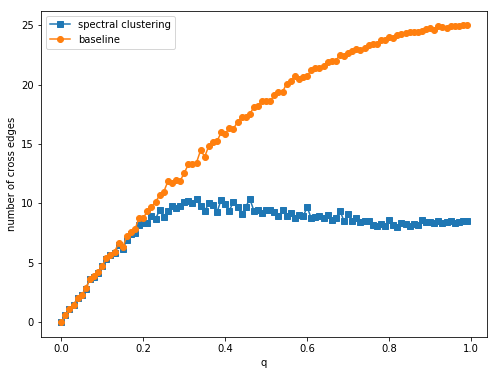

In [79]:
L = 100 # number of iterations to average over
n = 10
ground_truth = np.array([0,0,0,0,0,1,1,1,1,1])
k = 2
p = 0.8
qs = np.arange(0, 1, 0.01)
num_edges = np.zeros((len(qs), L))
baselines = np.zeros((len(qs), L))
for i, q in enumerate(qs):
    for l in xrange(L):
        adjacency = SBM(n, k, p, q)
        labels = spectral_clustering(adjacency, k)
        num_edges[i, l] = inter_cluster_edges(adjacency, labels)
        baselines[i, l] = inter_cluster_edges(adjacency, ground_truth)
        
rcParams['figure.figsize'] = 8, 6
plt.figure()
plt.plot(qs, np.average(num_edges, axis=1), marker='s', label='spectral clustering')
plt.plot(qs, np.average(baselines, axis=1), marker='o', label='baseline')
plt.legend()
plt.xlabel('q')
plt.ylabel('number of cross edges')

Try this code with different `p` and `q`. What happened? Can you think of an explanation why this phenomenon happens?

At lower q values, the minimization of cross edges due to spectral clustering is less different because there aren't many inter-community edges to begin with. When the value of q is larger, the minimization of cross edges becomes more prominent because the number of inter-community edges increases. Therefore, using spectral clustering can optimize the number of cross-edges better.